In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amzn-daily-stock-prices-dataset/AMZN_2012-05-19_2025-04-06.csv
/kaggle/input/amzn-daily-stock-prices-dataset/AMZN_2012-05-19_2025-05-12.csv
/kaggle/input/amzn-daily-stock-prices-dataset/AMZN_2012-05-19_2025-04-17.csv


In [2]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

2025-05-29 15:59:54.805423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748534395.017262      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748534395.075736      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv('/kaggle/input/amzn-daily-stock-prices-dataset/AMZN_2012-05-19_2025-04-06.csv')

In [4]:
df = df[['open', 'high', 'low', 'close', 'volume']].dropna()
df = df.drop([0], axis=0)
# Normalize data (optional, improves LSTM performance)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

close_prices = df['close'].values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 1 to 3237
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3237 non-null   float64
 1   high    3237 non-null   float64
 2   low     3237 non-null   float64
 3   close   3237 non-null   float64
 4   volume  3237 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 126.6 KB


In [6]:
df=df.astype(float)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 1 to 3237
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3237 non-null   float64
 1   high    3237 non-null   float64
 2   low     3237 non-null   float64
 3   close   3237 non-null   float64
 4   volume  3237 non-null   float64
dtypes: float64(5)
memory usage: 126.6 KB


In [8]:
window_size = 10
X_seq, X_lag, y = [], [], []

for i in range(window_size, len(scaled_data)):
    window = scaled_data[i - window_size:i]
    flat_window = window.flatten()  # for XGBoost
    X_seq.append(window)
    X_lag.append(flat_window)
    y.append(close_prices[i])  # unscaled close for evaluation

X_seq = np.array(X_seq)
X_lag = np.array(X_lag)
y = np.array(y)

In [10]:
X_seq_train, X_seq_test, X_lag_train, X_lag_test, y_train, y_test = train_test_split(
    X_seq, X_lag, y, test_size=0.2, shuffle=False)


In [11]:
model_lstm = Sequential([
    LSTM(64, input_shape=(window_size, 5)),
    Dense(1)
])
model_lstm.compile(loss='mae', optimizer=Adam(0.001))
model_lstm.fit(X_seq_train, y_train, epochs=200, batch_size=32, verbose=1)


I0000 00:00:1747938319.011286      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747938319.011973      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200


I0000 00:00:1747938323.004433      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 65.1129
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.0499
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.8158
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 49.4100
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 48.2643
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 47.5508
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 46.1833
Epoch 8/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 38.8315
Epoch 9/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 34.6152
Epoch 10/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 32.7823
Epoch 11/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30.3624
Epoch 12/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 27.2170
Epoch 13/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25.2011
Epoch 14/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 21.7079
Epoch 15/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.7253
E

In [12]:
model_xgb = XGBRegressor(n_estimators=100,device='cuda')
model_xgb.fit(X_lag_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [13]:
pred_lstm = model_lstm.predict(X_seq_test).flatten()
pred_xgb = model_xgb.predict(X_lag_test)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [18:26:32] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [14]:
print(mean_absolute_error(y_test, pred_lstm))
print(r2_score(y_test,pred_lstm))

5.3231529613766515
0.95159446977016


In [15]:
print(mean_absolute_error(y_test,pred_xgb))
print(r2_score(y_test,pred_xgb))

7.998787115232863
0.8815510576885061


In [16]:
X_meta = np.vstack((pred_lstm, pred_xgb)).T
meta_model = LinearRegression()
meta_model.fit(X_meta, y_test)
final_preds = meta_model.predict(X_meta)


In [17]:
print("Stacked MAE:", mean_absolute_error(y_test, final_preds))
print(r2_score(y_test,final_preds))

Stacked MAE: 4.000743511660549
0.9844370313524188


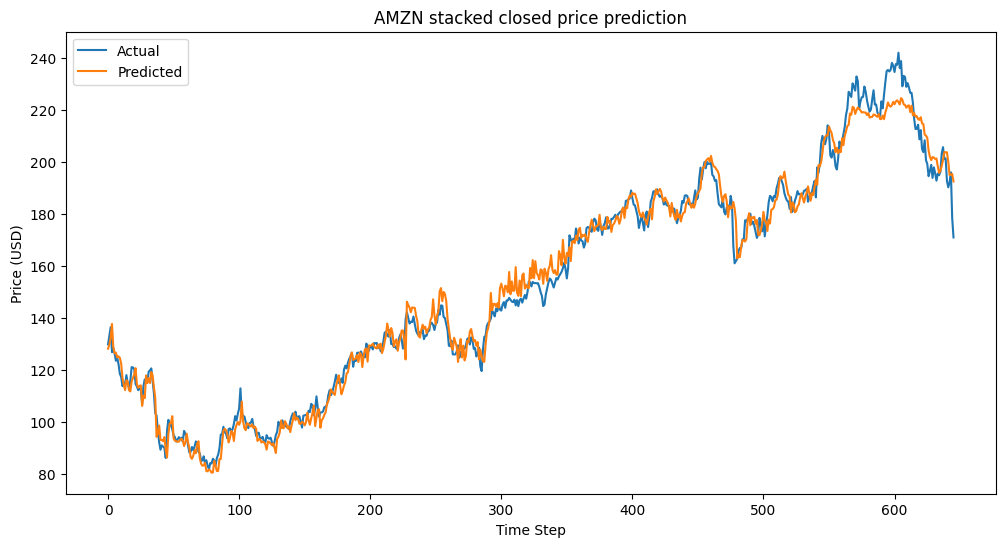

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual")
plt.plot(final_preds, label="Predicted")
plt.title("AMZN stacked closed price prediction")
plt.xlabel("Time Step")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()